In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/net_audio.zip" -d /content/net_audio
print("Extraction complete. Check /content/net_audio")


Extraction complete. Check /content/net_audio


In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Set the path to the extracted audio folder.
audio_folder = '/content/net_audio/net_audio'

# Initialize lists to store file paths and labels.
audio_files = []
labels = []

# Loop through each subfolder (instrument class).
for instrument in os.listdir(audio_folder):
    subfolder = os.path.join(audio_folder, instrument)
    if os.path.isdir(subfolder):
        for filename in os.listdir(subfolder):
            if filename.endswith('.mp3'):
                file_path = os.path.join(subfolder, filename)
                audio_files.append(file_path)
                labels.append(instrument)

print("Found {} audio files.".format(len(audio_files)))


Found 3979 audio files.


In [ ]:
def extract_features(file_path, n_mfcc=20):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        # Compute MFCC features; result shape is (n_mfcc, frames)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        # Take the mean of each coefficient over time
        mfccs_mean = np.mean(mfccs, axis=1)
    except Exception as e:
        print("Error processing {}: {}".format(file_path, e))
        return None
    return mfccs_mean

# Extract features for all audio files.
features = []
valid_labels = []

for f, lab in zip(audio_files, labels):
    feat = extract_features(f)
    if feat is not None:
        features.append(feat)
        valid_labels.append(lab)

X = np.array(features)
print("Feature matrix shape:", X.shape)


Feature matrix shape: (3979, 20)


In [ ]:
le = LabelEncoder()
y = le.fit_transform(valid_labels)
print("Discovered instrument classes:", le.classes_)

if len(le.classes_) != 4:
    print("WARNING: Expected exactly 4 instrument classes, but found {}.".format(len(le.classes_)))


Discovered instrument classes: ['cello' 'contrabassoon' 'flute' 'violin']


In [ ]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the SVM classifier
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Test Accuracy: 97.86%

Classification Report:
               precision    recall  f1-score   support

        cello       0.95      0.96      0.95       183
contrabassoon       1.00      0.98      0.99       131
        flute       1.00      0.99      1.00       160
       violin       0.98      0.98      0.98       322

     accuracy                           0.98       796
    macro avg       0.98      0.98      0.98       796
 weighted avg       0.98      0.98      0.98       796



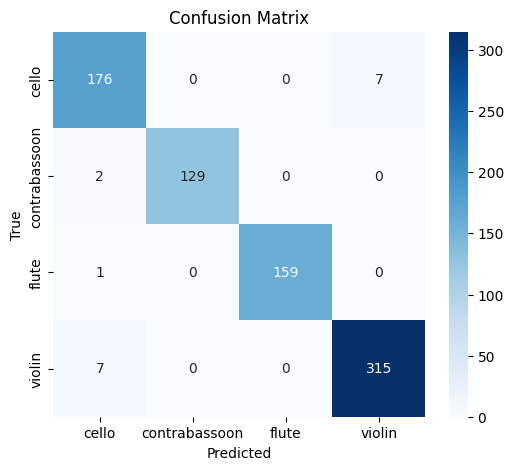

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Pick a sample audio file
sample_path = audio_files[0]
print("Predicting for file:", sample_path)

feat = extract_features(sample_path)
if feat is not None:
    feat = feat.reshape(1, -1)
    prediction = clf.predict(feat)
    predicted_label = le.inverse_transform(prediction)
    print("Predicted instrument:", predicted_label[0])

Predicting for file: /content/net_audio/net_audio/violin/violin_F7_05_pianissimo_arco-normal.mp3
Predicted instrument: violin


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (3183, 20) Test shape: (796, 20)


In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout


In [ ]:
def extract_feat(file_path, n_mfcc=20, max_pad_len=130):
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=None)
        # Compute MFCC (shape: [n_mfcc, time_steps])
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate along the time axis
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
    except Exception as e:
        print("Error processing {}: {}".format(file_path, e))
        return None
    # Transpose so that each sample has shape (time_steps, n_mfcc)
    return mfcc.T

# Loop through files to extract features
features = []
valid_labels = []
for f, lab in zip(audio_files, labels):
    feat = extract_feat(f)
    if feat is not None:
        features.append(feat)
        valid_labels.append(lab)

# Convert list into numpy array: shape = (num_samples, time_steps, n_mfcc)
X = np.array(features)
print("Feature matrix shape:", X.shape)



Feature matrix shape: (3979, 130, 20)


In [ ]:
le = LabelEncoder()
y_int = le.fit_transform(valid_labels)
print("Instrument classes:", le.classes_)

if len(le.classes_) != 4:
    print("WARNING: Expected exactly 4 instrument classes but found {}.".format(len(le.classes_)))

# One-hot encode labels
y = to_categorical(y_int, num_classes=len(le.classes_))


Instrument classes: ['cello' 'contrabassoon' 'flute' 'violin']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (3183, 130, 20) Test shape: (796, 130, 20)


In [ ]:
# Define input shape based on our features: (time_steps, n_mfcc)
time_steps, n_mfcc = X_train.shape[1], X_train.shape[2]
num_classes = y_train.shape[1]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, n_mfcc)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 128, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,158 (293.59 KB)

 Trainable params: 75,158 (293.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3631 - loss: 1.3039 - val_accuracy: 0.5808 - val_loss: 0.9804
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.5724 - loss: 0.9818 - val_accuracy: 0.6484 - val_loss: 0.8171
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6145 - loss: 0.8369 - val_accuracy: 0.6531 - val_loss: 0.8018
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6589 - loss: 0.7759 - val_accuracy: 0.7488 - val_loss: 0.6659
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7321 - loss: 0.6540 - val_accuracy: 0.8053 - val_loss: 0.5151
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7867 - loss: 0.5492 - val_accuracy: 0.7975 - val_loss: 0.5705
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7785 - loss: 0.5801 - val_accuracy: 0.8681 - val_loss: 0.3976
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8554 - loss: 0.4308 - val

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9800 - loss: 0.0554
Test Accuracy: 98.12%


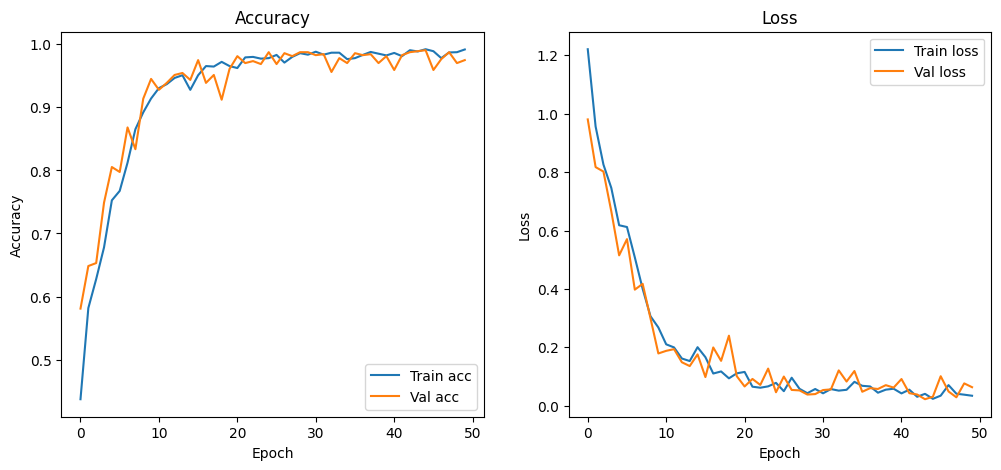

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
print("Shape of extracted feature:", feat.shape)


Shape of extracted feature: (1, 20)


In [ ]:
# Choose a sample from the audio file list
sample_path = audio_files[0]
print("Predicting for file:", sample_path)

feat = extract_feat(sample_path)
if feat is not None:
    feat = feat[np.newaxis, ...]  # Reshape to (1, time_steps, n_mfcc)
    prediction = model.predict(feat)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = le.inverse_transform(predicted_class)
    print("Predicted instrument:", predicted_label[0])


Predicting for file: /content/net_audio/net_audio/violin/violin_F7_05_pianissimo_arco-normal.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Predicted instrument: violin


**Utilizing pretrained models like VGG16 and EfficientNetB1, which have been trained on large datasets (e.g., ImageNet), and fine-tuning them on our Dataset**

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from torchvision.models import vgg16, VGG16_Weights, efficientnet_b1, EfficientNet_B1_Weights
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import Adam

In [ ]:
def generate_features(y_in, sr=28000, n_mels=128, fixed_length=128):
    y,_=librosa.load(y_in,sr=sr)
    # Compute Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    # Convert to Log Scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    # Fix length to ensure uniform shape
    return librosa.util.fix_length(mel_spec_db, size=fixed_length, axis=1)

In [ ]:
X=[]
y=[]
audio_folder = '/content/net_audio'
# Loop through each subfolder (instrument class).
for instrument in os.listdir(audio_folder):
    subfolder = os.path.join(audio_folder, instrument)
    print(subfolder)
    for f in os.listdir(subfolder):
        data=os.path.join(subfolder,f)
        for filename in os.listdir(data):
            if filename.endswith('.mp3'):
                file_path = os.path.join(data, filename)
                X.append(generate_features(file_path))
                y.append(f)

/content/net_audio/net_audio


In [ ]:
le = LabelEncoder()
y_label = le.fit_transform(y)

Class Distribution: {'cello': 1502, 'contrabassoon': 710, 'flute': 889, 'violin': 878}


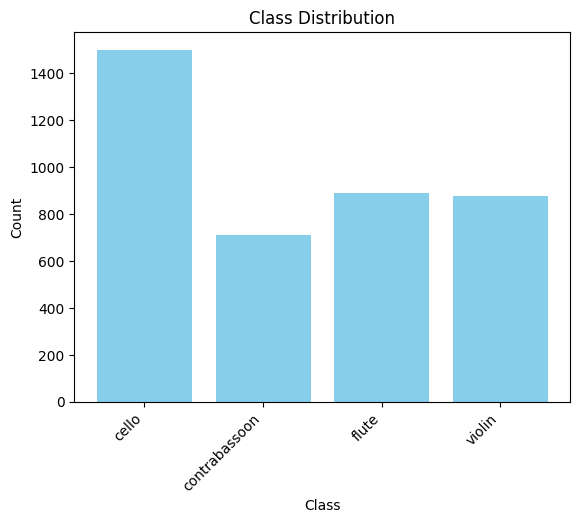

In [ ]:
class_counts = Counter(y_label)
class_names = le.classes_  # Get the class names
# Print class distribution
print("Class Distribution:", dict(zip(class_names, class_counts.values())))
# Visualize class distribution
plt.bar(class_names, class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha="right")  # Rotate labels to avoid overlap
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [ ]:
# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y_label, dtype=torch.long)
X_train = X_train.to(device)
y_train = y_train.to(device)

<ipython-input-8-6eb60017834f>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train = torch.tensor(X, dtype=torch.float32)


In [ ]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Modified VGG16
class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedVGG16, self).__init__()
        self.model = vgg16(weights=VGG16_Weights.DEFAULT)
        # Modify first conv layer to accept 1-channel input (for grayscale)
        self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # print(f"Input shape to VGG16: {x.shape}")
        return self.model(x)
# Define the Model
num_classes = 4
model2 = ModifiedVGG16(num_classes).to(device)
# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(
    model2.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8,  # Default for Adam
    weight_decay=0
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.7MB/s]


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs=inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch [1/10], Loss: 1.0592
Epoch [2/10], Loss: 0.4479
Epoch [3/10], Loss: 0.1855
Epoch [4/10], Loss: 0.0823
Epoch [5/10], Loss: 0.0417
Epoch [6/10], Loss: 0.0347
Epoch [7/10], Loss: 0.0281
Epoch [8/10], Loss: 0.0190
Epoch [9/10], Loss: 0.0173
Epoch [10/10], Loss: 0.0287
Training complete!


Test Accuracy: 99.50%


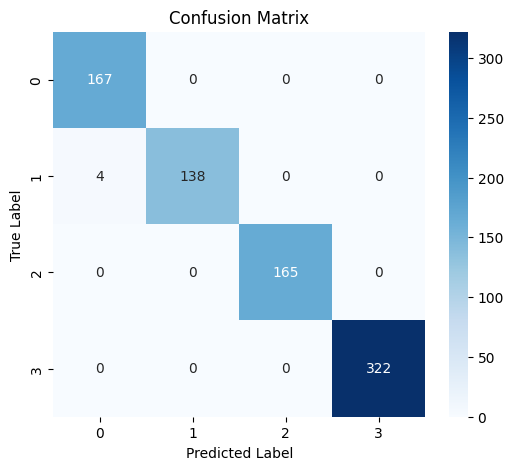

In [ ]:
model2.eval()  # Set to evaluation mode
y_true, y_pred = [], []

correct, total = 0, 0
with torch.no_grad():  # No need to compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Ensure correct shape
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())   # Store true labels
        y_pred.extend(predicted.cpu().numpy())  # Store predicted labels

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(num_classes)]  # Adjust class names if needed

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Define the Modified EfficientNet
class ModifiedEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedEfficientNet, self).__init__()
        self.model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
        # Modify first conv layer to accept 1-channel input (grayscale spectrogram)
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        num_ftrs = self.model.classifier[1].in_features
        # New fully connected layers before softmax
        self.extra_layers = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),  # Dropout for regularization

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),  # Dropout for regularization

            nn.Linear(256, num_classes)  # Final output layer
        )

    def forward(self, x):
        x = self.model.features(x)  # Extract features
        x = self.model.avgpool(x)  # Global Average Pooling
        x = torch.flatten(x, 1)  # Flatten for FC layers
        x = self.extra_layers(x)  # Pass through new layers
        return x

# Define Model
num_classes = 4
model = ModifiedEfficientNet(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 170MB/s]


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW is better for deep networks)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Add channel dimension -> (batch_size, 1, 128, 128)
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

print("Training Complete!")

Epoch [1/10], Loss: 1.1424, Accuracy: 49.45%
Epoch [2/10], Loss: 0.6868, Accuracy: 73.64%
Epoch [3/10], Loss: 0.4490, Accuracy: 83.79%
Epoch [4/10], Loss: 0.3029, Accuracy: 89.48%
Epoch [5/10], Loss: 0.2211, Accuracy: 92.96%
Epoch [6/10], Loss: 0.1737, Accuracy: 94.38%
Epoch [7/10], Loss: 0.1388, Accuracy: 95.41%
Epoch [8/10], Loss: 0.1203, Accuracy: 96.23%
Epoch [9/10], Loss: 0.0988, Accuracy: 96.98%
Epoch [10/10], Loss: 0.0876, Accuracy: 97.33%
Training Complete!


Test Accuracy: 98.87%


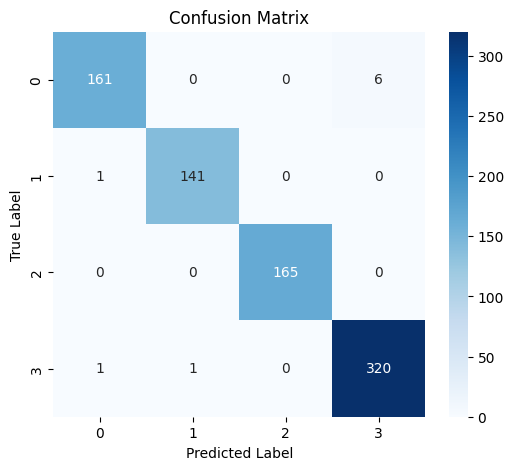

In [ ]:
model.eval()  # Set to evaluation mode
y_true, y_pred = [], []

correct, total = 0, 0
with torch.no_grad():  # No need to compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Ensure correct shape
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        y_true.extend(labels.cpu().numpy())   # Store true labels
        y_pred.extend(predicted.cpu().numpy())  # Store predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Compute confusion matrix
# Compute accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(num_classes)]  # Adjust class names if needed

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()